In [1]:
import numpy as np
import itertools
import pandas as pd
from scipy.stats import multivariate_normal, norm
import gurobipy as gp
from gurobipy import GRB
from IPython.display import display, Math
from gurobipy import GRB, quicksum
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product, combinations
from scipy.spatial.distance import cdist
from collections import Counter

## Matching Approach Simulation

#### Limitations

After changing the decision variable weight $w_i$ as binary number and objective function into maximize the sample size, if I continue follow the weight balancing constraints, it means force the selected subset to exactly replicate the entire sample’s sum of covariates in the plus and minus group, the entire sample’s sum in the minus group, etc. This will be most likely infeasible if $w_i \in{0,1}$. It cannot pick a strict subset that exactly reproduces the entire sample’s sums.

Therefore, for the heterogeneous constraints, I added a slack variable in the objective function with penalty to further relax the tolerance. 


In [2]:
np.random.seed(123)

D = 5  # number of covariates
K = 3 # number of binary covariates
rho = 0.0 # correlation
Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)
# constructs a covariance matrix where diagonal elements are 1 and off-diagonal elements are rho.
# when rho = 0.0, Sigma is an identity matrix, meaning all covariates are independent.

# coefficient vectors for generating Z 
# beta1 = np.array([ 1/4,  2/4,  0.0,  3/4,  1.0])
# beta2 = np.array([ 3/4,  1/4,  1.0,  0.0,  2/4])
# beta3 = np.array([ 1.0,  0.0,  3/4,  2/4,  1/4])

# beta1 = np.array([0.15, 0.05, 0.05, 0.10, 0.00])
# beta2 = np.array([0.05, 0.15, 0.05, 0.00, 0.10])
# beta3 = np.array([0.05, 0.05, 0.15, 0.10, 0.00])

# beta1 = np.array([ 0.30,  0.10,  0.00,  0.20,  0.00])
# beta2 = np.array([ 0.10,  0.30,  0.00,  0.00,  0.20])
# beta3 = np.array([ 0.00,  0.10,  0.30,  0.20,  0.00])


beta1 = np.array([ 0.40,  0.30,  0.00,  0.20,  0.40])
beta2 = np.array([ 0.40,  0.40,  0.30,  0.00,  0.20])
beta3 = np.array([ 0.20,  0.40,  0.30,  0.20,  0.20])


# Estimate tau_1, tau_2, tau_3 under each outcome model.

# implements the logistic function for probability calculations
def logistic(x): 
    return 1.0 / (1.0 + np.exp(-x))

# assigns +1 or -1 to Z1, Z2, Z3 based on these probabilities p1, p2, p3
def generate_treatments(X):
    # initializes a Z matrix (N x K) where each row represents an individual's treatment status.
    Z = np.zeros((X.shape[0], K)) 
    # computes treatment probabilities using logistic regression.
    p1 = logistic(X @ beta1)
    ## add a alpha in the intercept
    # assigns +1 or -1 to Z1, Z2, Z3 based on these probabilities p1, p2, p3
    Z1 = (np.random.rand(X.shape[0]) < p1).astype(int)*2 - 1
    Z[:, 0] = Z1

    p2 = logistic(X @ beta2)
    Z2 = (np.random.rand(X.shape[0]) < p2).astype(int)*2 - 1
    Z[:, 1] = Z2

    p3 = logistic(X @ beta3)
    Z3 = (np.random.rand(X.shape[0]) < p3).astype(int)*2 - 1
    Z[:, 2] = Z3

    return Z

def make_contrast_vectors(K):
    # generates all 2^K possible combinations of treatments, each treatment can be -1 or +1
    combos = np.array(list(product([-1,1], repeat=K)))  # shape (8,3)
    # main-effect vectors
    # creates contrast vectors for each treatment
    g = {}
    for k in range(K):
        # assigns +1 if the treatment is +1, otherwise assigns -1
        gk = np.where(combos[:, k] == +1, +1, -1) 
        g[k+1] = gk

    return g, combos

g_dict, Z_all = make_contrast_vectors(K)  # Z_all is shape (8,3), the matrix of all possible treatment assignments

# generate true main effects
def true_main_effects(Yfn, combos=Z_all):
    # generates a large population (bigN = 200000) for estimating expected treatment effects
    bigN = 200000  
    # generates samples from a multivariate normal distribution with mean vector [0, 0, 0, 0, 0]
    Xbig = np.random.multivariate_normal(np.zeros(D), Sigma, size=bigN) 
    # match the simulation in section 5.1 where mu = (0.1, 0.1, 0.1, 0, 0).T
    Xbig[:,0] += 0.1
    Xbig[:,1] += 0.1
    Xbig[:,2] += 0.1
    
    # store expected outcomes for each treatment combination
    EYZ = np.zeros(len(combos)) 
    for i,z in enumerate(combos):
        # expands z across bigN rows
        Zbig = np.tile(z, (bigN, 1))  # shape (bigN,3)
        # computes expected outcomes for treatment z using function Yfn(Xbig, Zbig).
        Evals = Yfn(Xbig, Zbig)       # now shape (bigN,)
        # stores the mean outcome for each treatment condition
        EYZ[i] = np.mean(Evals)

    tau = {}
    factor = 1 / (2 ** (K - 1))  # Compute the factor for scaling
    for k in range(1, K+1):
        # retrieves contrast vector for the k-th treatment.
        gk = g_dict[k]
        # computes the main effect estimate
        #tau_k = np.mean(gk * EYZ)  
        tau_k = factor * np.dot(gk, EYZ)  
        tau[k] = tau_k
    return tau


def Y_model_additive(X, Z):
    sumX = 2 * np.sum(X, axis=1)  # factor 2
    sumZ = np.sum(Z, axis=1)
    return sumX + sumZ

def Y_model_het(X, Z):
    sumX = np.sum(X, axis=1)*2.0
    sumZ = np.sum(Z, axis=1)
    return sumX + (np.sum(X, axis=1)*sumZ)

# def Y_model_mis(X, Z):
#     X1 = X[:,0]
#     X2 = X[:,1]
#     part1 = np.sin(X1) + np.cos(X2)
#     part2 = (np.minimum(1.0, X1) + X2) * Z[:,0]
#     # sum_i(X_i) * sum_{j=2..3}(Z_j)
#     part3 = np.sum(X, axis=1) * np.sum(Z[:,1:], axis=1)
#     return part1 + part2 + part3

def Y_model_mis(X, Z):
    # nonlinear pieces
    f1 =  2.0 * np.sin(X[:, 0])            # sin X₁
    f2 =  1.5 * np.cos(X[:, 1])            # cos X₂
    f3 =  0.8 * X[:, 2]**2                 # quadratic term
    f4 =  1.2 * np.log(np.abs(X[:, 3]) + 1.1) * Z[:,0]  # log term
    f5 =  np.sum(X, axis=1) * np.sum(Z[:,1:], axis=1)        
    return f1 + f2 + f3 + f4 + f5 


def simulate_Y(X, Z, model="additive"):
    if model=="additive":
        meanY = Y_model_additive(X, Z)
    elif model=="heterogeneous":
        meanY = Y_model_het(X, Z)
    elif model=="misspecified":
        meanY = Y_model_mis(X, Z)
    else:
        raise ValueError("Unknown model")
    return meanY + np.random.randn(len(X))  # add normal(0,1)

def solve_weights_heterogeneous(X, Z):
    N, D = X.shape
    K = Z.shape[1]
    model = gp.Model("HeteroExactAll")
    model.setParam('OutputFlag', 0)
    w_vars = model.addVars(N, lb=0.0, name="w")

    basis_vals = [np.ones(N)] + [X[:, d] for d in range(D)]
    n_s = len(basis_vals)

    J_list = [()] + [(j,) for j in range(K)]
    n_J = len(J_list)

    Qvals = np.zeros((N, n_s, n_J))
    for j_idx, J in enumerate(J_list):
        Zp = np.prod(Z[:, list(J)], axis=1) if J else np.ones(N)
        for s in range(n_s):
            Qvals[:, s, j_idx] = basis_vals[s] * Zp / N

    Aplus = (Z > 0).astype(float)
    Aminus = 1.0 - Aplus

    Z_all = np.array(list(product([-1, 1], repeat=K)))
    bigQ = np.zeros((len(Z_all), n_s, n_J))
    for z_idx, z in enumerate(Z_all):
        for j_idx, J in enumerate(J_list):
            z_prod = np.prod([z[j] for j in J]) if J else 1.0
            for s in range(n_s):
                #bigQ[z_idx, s, j_idx] = z_prod * np.sum(basis_vals[s]) 
                bigQ[z_idx, s, j_idx] = z_prod * np.sum(basis_vals[s]) / N

    factor = 1.0 / (2.0 ** (K - 1))
    target_plus = np.zeros((K, n_s, n_J))
    target_minus = np.zeros((K, n_s, n_J))

    for k in range(K):
        for z_idx, z in enumerate(Z_all):
            g_plus = 1.0 if z[k] == 1 else 0.0
            g_minus = 1.0 if z[k] == -1 else 0.0
            for s in range(n_s):
                for j_idx in range(n_J):
                    target_plus[k, s, j_idx] += factor * g_plus * bigQ[z_idx, s, j_idx]
                    target_minus[k, s, j_idx] += factor * g_minus * bigQ[z_idx, s, j_idx]

    obj = gp.QuadExpr()
    for i in range(N):
        obj += w_vars[i] * w_vars[i]
    model.setObjective(obj, gp.GRB.MINIMIZE)

    for k in range(K):
        for s in range(n_s):
            for j_idx in range(n_J):
                lhs_plus = gp.quicksum(Aplus[i, k] * Qvals[i, s, j_idx] * w_vars[i] for i in range(N))
                lhs_minus = gp.quicksum(Aminus[i, k] * Qvals[i, s, j_idx] * w_vars[i] for i in range(N))
                model.addConstr(lhs_plus == target_plus[k, s, j_idx])
                model.addConstr(lhs_minus == target_minus[k, s, j_idx])

    model.optimize()
    if model.status != gp.GRB.OPTIMAL:
        return None
    return np.array([w_vars[i].X for i in range(N)])

def solve_matching_heterogeneous(X, Z, lambda_penalty=100.0):
    N, D = X.shape
    K = Z.shape[1]
    model = gp.Model("MatchingAll")
    model.setParam('OutputFlag', 0)

    w_vars = model.addVars(N, vtype=gp.GRB.BINARY, name="w")
    basis_vals = [np.ones(N)] + [X[:, d] for d in range(D)]
    n_s = len(basis_vals)

    J_list = [()] + [(j,) for j in range(K)]
    n_J = len(J_list)

    Qvals = np.zeros((N, n_s, n_J))
    for j_idx, J in enumerate(J_list):
        Zp = np.prod(Z[:, list(J)], axis=1) if J else np.ones(N)
        for s in range(n_s):
            Qvals[:, s, j_idx] = basis_vals[s] * Zp / N

    Aplus = (Z > 0).astype(float)
    Aminus = 1.0 - Aplus

    Z_all = np.array(list(product([-1, 1], repeat=K)))
    bigQ = np.zeros((len(Z_all), n_s, n_J))
    for z_idx, z in enumerate(Z_all):
        for j_idx, J in enumerate(J_list):
            z_prod = np.prod([z[j] for j in J]) if J else 1.0
            for s in range(n_s):
                #bigQ[z_idx, s, j_idx] = z_prod * np.sum(basis_vals[s])
                bigQ[z_idx, s, j_idx] = z_prod * np.sum(basis_vals[s]) / N

    factor = 1.0 / (2.0 ** (K - 1))
    target_plus = np.zeros((K, n_s, n_J))
    target_minus = np.zeros((K, n_s, n_J))

    for k in range(K):
        for z_idx, z in enumerate(Z_all):
            g_plus = 1.0 if z[k] == 1 else 0.0
            g_minus = 1.0 if z[k] == -1 else 0.0
            for s in range(n_s):
                for j_idx in range(n_J):
                    target_plus[k, s, j_idx] += factor * g_plus * bigQ[z_idx, s, j_idx]
                    target_minus[k, s, j_idx] += factor * g_minus * bigQ[z_idx, s, j_idx]

    slack_vars = []
    for k in range(K):
        for s in range(n_s):
            for j_idx in range(n_J):
                lhs_plus = gp.quicksum(Aplus[i, k] * Qvals[i, s, j_idx] * w_vars[i] for i in range(N))
                lhs_minus = gp.quicksum(Aminus[i, k] * Qvals[i, s, j_idx] * w_vars[i] for i in range(N))

                slack_plus = model.addVar(lb=0.0, name=f"slack_plus_{k}_{s}_{j_idx}")
                slack_minus = model.addVar(lb=0.0, name=f"slack_minus_{k}_{s}_{j_idx}")

                model.addConstr(lhs_plus - target_plus[k, s, j_idx] <= slack_plus)
                model.addConstr(lhs_plus - target_plus[k, s, j_idx] >= -slack_plus)

                model.addConstr(lhs_minus - target_minus[k, s, j_idx] <= slack_minus)
                model.addConstr(lhs_minus - target_minus[k, s, j_idx] >= -slack_minus)

                slack_vars.extend([slack_plus, slack_minus])

    total_slack = gp.quicksum(slack_vars)
    model.setObjective(gp.quicksum(w_vars[i] for i in range(N)) - lambda_penalty * total_slack, gp.GRB.MAXIMIZE)

    model.optimize()
    if model.status != gp.GRB.OPTIMAL:
        return None
    return np.array([w_vars[i].X for i in range(N)])

def interaction_regression(Y, X, Z):
    N, D = X.shape
    K = Z.shape[1]
    design_list = [np.ones(N)]  # intercept

    # Add X and Z main effects
    for d_ in range(D):
        design_list.append(X[:, d_])
    for k_ in range(K):
        design_list.append(Z[:, k_])

    # Add 2-way interactions: X_j * Z_k
    for d_ in range(D):
        for k_ in range(K):
            design_list.append(X[:, d_] * Z[:, k_])

    # Add 3-way interactions: X_j * Z_k * Z_l (k < l)
    for d_ in range(D):
        for k1 in range(K):
            for k2 in range(k1 + 1, K):
                design_list.append(X[:, d_] * Z[:, k1] * Z[:, k2])

    Xd = np.column_stack(design_list)
    model = sm.OLS(Y, Xd).fit()
    coefs = model.params

    out = {}
    for k_ in range(K):
        zcoef = coefs[D + 1 + k_]  # main effect of Z_k
        out[k_ + 1] = 2 * zcoef
    return out

def estimate_main_effects_weighted(Y, Z, w):
    N = len(Y)
    K = Z.shape[1]
    Aplus = (Z>0).astype(float)   # shape (N,K)
    Aminus= 1.0 - Aplus

    tau_est = {}
    for k in range(K):
        w_plus_sum  = np.sum(w * Aplus[:, k])
        w_minus_sum = np.sum(w * Aminus[:, k])

        tau_plus  = np.sum(w * Aplus[:, k]  * Y) / w_plus_sum
        tau_minus = np.sum(w * Aminus[:, k] * Y) / w_minus_sum
        tau_est[k + 1] = tau_plus - tau_minus

    return tau_est

def estimate_main_effects_original(Y, Z):
    K = Z.shape[1]
    tau_est = {}
    for k_ in range(K):
        plus_mask  = (Z[:, k_] == +1)
        minus_mask = (Z[:, k_] == -1)
        if np.sum(plus_mask) < 1 or np.sum(minus_mask) < 1:
            tau_est[k_+1] = np.nan
        else:
            mean_plus = np.mean(Y[plus_mask])
            mean_minus = np.mean(Y[minus_mask])
            tau_est[k_+1] = mean_plus - mean_minus
    return tau_est

#  Do an naive difference in means for each factor to estimate the factorial effect
def estimate_main_effects_matched(Y, Z, match_vec):
    # Weighted means become simple means if match_vec is 0/1
    # tau_k = mean(Y | Z_k=+1 & matched) - mean(Y | Z_k=-1 & matched)
    tau_est_matched = {}
    K = Z.shape[1]
    for k_ in range(K):
        plus_mask  = (Z[:, k_] == +1) & (match_vec == 1)
        minus_mask = (Z[:, k_] == -1) & (match_vec == 1)
        if np.sum(plus_mask) < 1 or np.sum(minus_mask) < 1:
            tau_est_matched[k_+1] = np.nan
        else:
            mean_plus  = np.mean(Y[plus_mask])
            mean_minus = np.mean(Y[minus_mask])
            tau_est_matched[k_+1] = mean_plus - mean_minus
    return tau_est_matched

def get_covariate_balance(X, Z, w):
    K = Z.shape[1]
    D = X.shape[1]
    # Overall (unweighted) standard deviation of each covariate
    sd_X = np.std(X, axis=0, ddof=1)  # shape (D,)

    smd = np.zeros((K, D))

    for k_ in range(K):
        # Mask for plus/minus
        plus_mask  = (Z[:, k_] == +1)
        minus_mask = (Z[:, k_] == -1)

        w_plus_sum  = np.sum(w[plus_mask])
        w_minus_sum = np.sum(w[minus_mask])

        # Weighted mean of X[:, d_] in the plus group
        x_plus_mean  = np.sum(w[plus_mask, None]  * X[plus_mask],  axis=0) / (w_plus_sum)
        # Weighted mean in the minus group
        x_minus_mean = np.sum(w[minus_mask, None] * X[minus_mask], axis=0) / (w_minus_sum)

        diff = x_plus_mean - x_minus_mean

        for d_ in range(D):
            if sd_X[d_] < 1e-15:
                smd[k_, d_] = 0.0  
            else:
                smd[k_, d_] = diff[d_] / sd_X[d_]

    return smd

# Getting the standardized mean difference (SMD) for each factor k and each covariate dimension d
def get_covariate_balance_matched(X, Z, selection):
    K = Z.shape[1]
    D = X.shape[1]
    sd_X = np.std(X, axis=0, ddof=1)
    smd = np.zeros((K, D))
    for k in range(K):
        plus_mask = (Z[:, k] == +1) & (selection == 1)
        minus_mask = (Z[:, k] == -1) & (selection == 1)
        if np.sum(plus_mask) > 0:
            mean_plus = np.mean(X[plus_mask], axis=0)
        else:
            mean_plus = np.full(X.shape[1], np.nan)
        if np.sum(minus_mask) > 0:
            mean_minus = np.mean(X[minus_mask], axis=0)
        else:
            mean_minus = np.full(X.shape[1], np.nan)
        diff = mean_plus - mean_minus
        smd[k, :] = diff / (sd_X)
    return smd

# print an array with 5 significant figures per float.
def print_array_5sig(arr):
    with np.printoptions(formatter={'float_kind': lambda x: f"{x:.5g}"}):
        print(arr)

def run_all_simulations(n_sims=100, N=500, lambda_penalty=100.0, show_progress=True):
    # Outcome models for RMSE simulation.
    outcome_models = ["additive", "heterogeneous", "misspecified"]

    model_fn = {"additive": Y_model_additive, "heterogeneous": Y_model_het, "misspecified": Y_model_mis}

    true_tau_dict = {m: true_main_effects(fn) for m, fn in model_fn.items()}

    rmse_sq = {m: {"het_matching": [], "het_weighting": [],
                   "orig": [], "het_regression": []}
               for m in outcome_models}
    smd_res = {"orig": [], "het_matching": [], "het_weighting": []}
    ess_list = []

    for sim in range(n_sims):
        if show_progress:
            print(f"simulation {sim+1:>3}/{n_sims}", end='\r')

        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0])
        X = np.random.multivariate_normal(mu, Sigma, size=N)
        Z = generate_treatments(X)

        smd_res["orig"].append(get_covariate_balance_matched(X, Z, np.ones(N)))

        match_sel = solve_matching_heterogeneous(X, Z, lambda_penalty)
        weights = solve_weights_heterogeneous(X, Z)

        smd_res["het_matching"].append(
            get_covariate_balance_matched(X, Z, match_sel)
            if match_sel is not None else np.full((K, D), np.nan))

        smd_res["het_weighting"].append(
            get_covariate_balance(X, Z, weights)
            if weights is not None else np.full((K, D), np.nan))

        ess_list.append(np.sum(match_sel) if match_sel is not None else np.nan)

        for m in outcome_models:
            Y  = simulate_Y(X, Z, model=m)
            true_vec = np.array([true_tau_dict[m][k] for k in (1, 2, 3)])

            # original
            est = estimate_main_effects_original(Y, Z)
            rmse_sq[m]["orig"].append((np.array([est[1], est[2], est[3]]) - true_vec) ** 2)

            # matching
            if match_sel is not None:
                estH = estimate_main_effects_matched(Y, Z, match_sel)
                rmse_sq[m]["het_matching"].append(
                    (np.array([estH[1], estH[2], estH[3]]) - true_vec) ** 2)
            else:
                rmse_sq[m]["het_matching"].append(np.full(3, np.nan))

            # weighting
            if weights is not None:
                estW = estimate_main_effects_weighted(Y, Z, weights)
                rmse_sq[m]["het_weighting"].append(
                    (np.array([estW[1], estW[2], estW[3]]) - true_vec) ** 2)
            else:
                rmse_sq[m]["het_weighting"].append(np.full(3, np.nan))

            # regression
            estR = interaction_regression(Y, X, Z)
            rmse_sq[m]["het_regression"].append(
                (np.array([estR[1], estR[2], estR[3]]) - true_vec) ** 2)

    aggregated_rmse = {}
    for m in outcome_models:
        aggregated_rmse[m] = {
            "true_tau": true_tau_dict[m],
            "rmse_orig": np.sqrt(np.nanmean(rmse_sq[m]["orig"], axis=0)),
            "rmse_het_regression": np.sqrt(np.nanmean(rmse_sq[m]["het_regression"], axis=0)),
            "rmse_het_weighting": np.sqrt(np.nanmean(rmse_sq[m]["het_weighting"], axis=0)),
            "rmse_het_matching": np.sqrt(np.nanmean(rmse_sq[m]["het_matching"], axis=0)),
        }

    aggregated_smd = {meth: np.nanmean(np.array(smd_res[meth]), axis=0)
                      for meth in smd_res}

    return {
        "rmse": aggregated_rmse,
        "smd":  aggregated_smd,
        "ess":  {"mean_ess_het": np.nanmean(ess_list)}
    }


In [3]:
np.random.seed(123)

if __name__ == "__main__":
    sim = run_all_simulations(n_sims=100, N=1000, lambda_penalty=160.0, show_progress=True)
    print("\n================  RMSE Results  =================")
    for mtype in ["additive", "heterogeneous", "misspecified"]:
        rm = sim["rmse"][mtype]
        tau_vec = np.array([rm["true_tau"][k] for k in (1, 2, 3)])  # order 1-2-3
        print(f"\nModel: {mtype}")
        print("   true main effects : ", tau_vec)
        print("   RMSE  (original)  : ", rm["rmse_orig"])
        print("   RMSE  (regress.)  : ", rm["rmse_het_regression"])
        print("   RMSE  (weighting) : ", rm["rmse_het_weighting"])
        print("   RMSE  (matching)  : ", rm["rmse_het_matching"])

    print("\n================  Average SMD  ==================")
    for meth in ["orig", "het_weighting", "het_matching"]:
        print(f"{meth:>14}:")
        print_array_5sig(sim["smd"][meth])
        print()

    print("\n============  Effective Sample Size  ============")
    print(f"mean ESS (heterogeneous matching) : "
          f"{sim['ess']['mean_ess_het']:.1f}")

Set parameter Username
Set parameter LicenseID to value 2622621
Academic license - for non-commercial use only - expires 2026-02-16
simulation   4/100
Interrupt request received
simulation 100/100
================  RMSE Results  =================

Model: additive
   true main effects :  [2. 2. 2.]
   RMSE  (original)  :  [2.58618668 2.61198131 2.73083436]
   RMSE  (regress.)  :  [0.06594911 0.07124739 0.07044746]
   RMSE  (weighting) :  [0.06596168 0.07121294 0.07096384]
   RMSE  (matching)  :  [0.61593532 0.77467354 0.64240471]

Model: heterogeneous
   true main effects :  [0.59254953 0.59254953 0.59254953]
   RMSE  (original)  :  [2.46018793 2.44437183 2.57686227]
   RMSE  (regress.)  :  [0.58779468 0.58919777 0.60412185]
   RMSE  (weighting) :  [0.15731753 0.16085499 0.1655151 ]
   RMSE  (matching)  :  [1.0292431  1.16574567 1.04586563]

Model: misspecified
   true main effects :  [0. 0. 0.]
   RMSE  (original)  :  [0.99769588 1.0430342  0.88914682]
   RMSE  (regress.)  :  [0.134977

In [ ]:
np.random.seed(123)

if __name__ == "__main__":
    simulation = run_all_simulations(n_sims=20, N=1000, lambda_penalty=300.0, show_progress=True)
    print("\n================  RMSE Results  =================")
    for mtype in ["additive", "heterogeneous", "misspecified"]:
        rm = simulation["rmse"][mtype]
        tau_vec = np.array([rm["true_tau"][k] for k in (1, 2, 3)])  # order 1-2-3
        print(f"\nModel: {mtype}")
        print("   true main effects : ", tau_vec)
        print("   RMSE  (original)  : ", rm["rmse_orig"])
        print("   RMSE  (regress.)  : ", rm["rmse_het_regression"])
        print("   RMSE  (weighting) : ", rm["rmse_het_weighting"])
        print("   RMSE  (matching)  : ", rm["rmse_het_matching"])

    print("\n================  Average SMD  ==================")
    for meth in ["orig", "het_weighting", "het_matching"]:
        print(f"{meth:>14}:")
        print_array_5sig(simulation["smd"][meth])
        print()

    print("\n============  Effective Sample Size  ============")
    print(f"mean ESS (heterogeneous matching) : "
          f"{simulation['ess']['mean_ess_het']:.1f}")

simulation   2/20
Interrupt request received
simulation   3/20
Interrupt request received


### The plots

#### The plot of the root mean squared error (RMSE) for estimating three main effects over 100 repetitions using 3 estimators when N = 1000 and $\rho$ = 0.

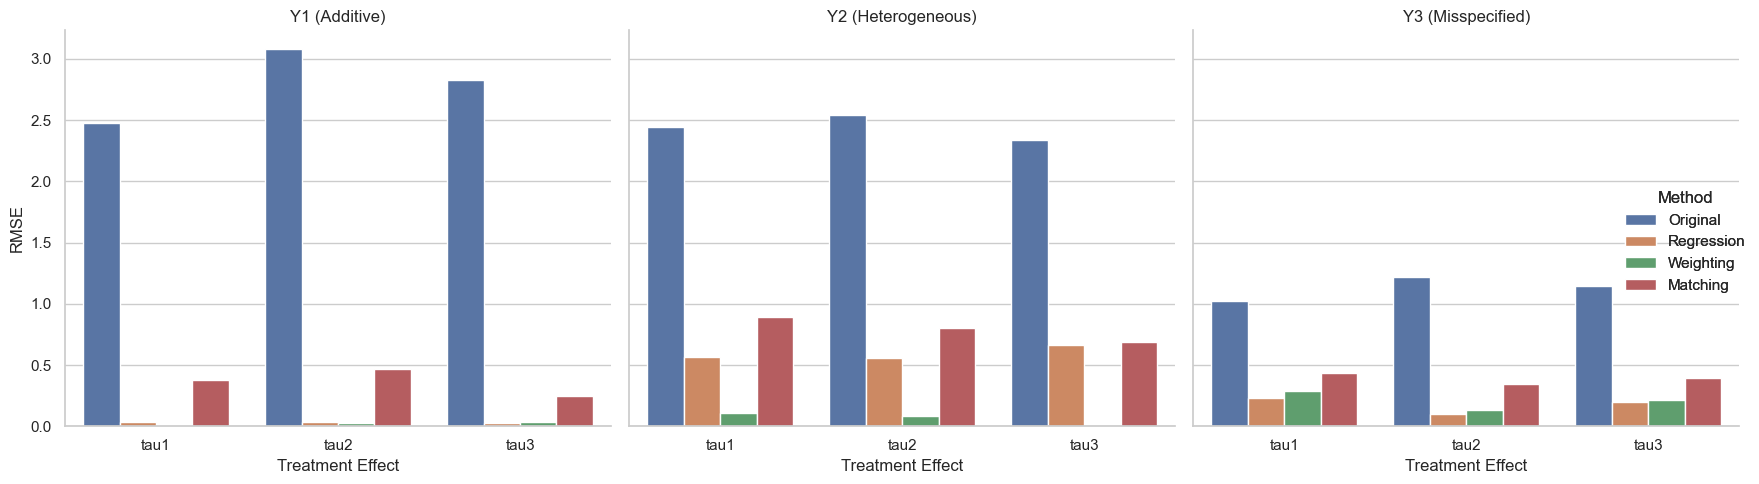

In [5]:
def plot_all_simulation_results(sim_dict):
    sns.set(style="whitegrid")

    rmse_results = sim_dict["rmse"]         
    effects = ['tau1', 'tau2', 'tau3']

    methods_rmse = ["rmse_orig",
                         "rmse_het_regression",
                         "rmse_het_weighting",
                         "rmse_het_matching"]
    method_names_rmse = ["Original", "Regression", "Weighting", "Matching"]

    models = {"additive": "Y1 (Additive)",
              "heterogeneous": "Y2 (Heterogeneous)",
              "misspecified": "Y3 (Misspecified)"}

    rows = []
    for mtype, res in rmse_results.items():
        for key, pretty in zip(methods_rmse, method_names_rmse):
            for i, eff in enumerate(effects):
                rows.append([models[mtype], eff, res[key][i], pretty])

    df_rmse = pd.DataFrame(rows,
                           columns=["Outcome Model", "Effect", "RMSE", "Method"])

    g = sns.catplot(data=df_rmse,
                    x="Effect", y="RMSE",
                    hue="Method", col="Outcome Model",
                    kind="bar", height=5, aspect=1)
    g.set_axis_labels("Treatment Effect", "RMSE")
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=0)
    g.add_legend(title="Method")
    plt.tight_layout()
    plt.show()

plot_all_simulation_results(simulation)

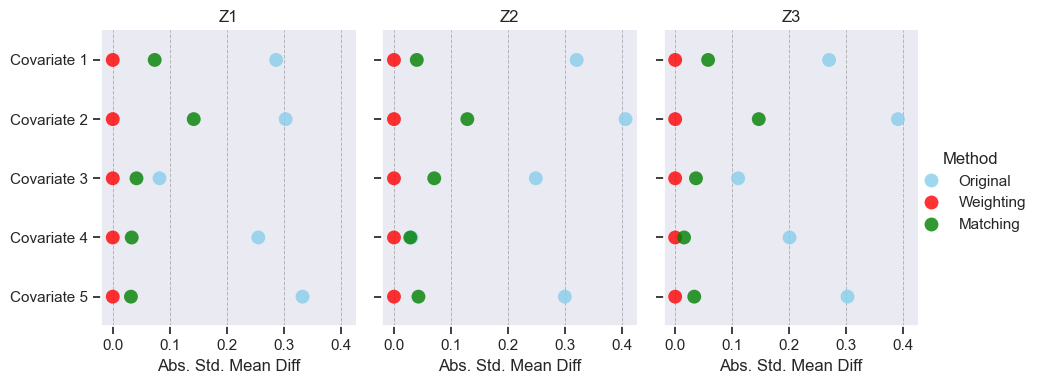

In [6]:

def plot_smd_by_treatment_group(smd_dict):
    cov_names = [f"Covariate {i+1}" for i in range(smd_dict["orig"].shape[1])]
    methods   = {"orig": "Original",
                 "het_weighting": "Weighting",
                 "het_matching":  "Matching"}

    rows = []
    for k in range(3):                        # Z1, Z2, Z3
        for d, cname in enumerate(cov_names):
            for key, pretty in methods.items():
                rows.append({
                    "Treatment": f"Z{k+1}",
                    "Covariate": cname,
                    "Method":    pretty,
                    "SMD":       abs(smd_dict[key][k, d])
                })

    df = pd.DataFrame(rows)

    sns.set(style="whitegrid")
    sns.set_theme(
        style="ticks",
        rc={"axes.facecolor": "#EAEAF2", "axes.edgecolor": "white",
            "grid.color": "white", "grid.linewidth": 1.2})

    g = sns.catplot(data=df,
                    x="SMD", y="Covariate",
                    hue="Method", col="Treatment",
                    kind="strip",
                    dodge=False,
                    jitter=False,
                    height=4, aspect=0.8,
                    palette={"Original": "skyblue",
                             "Weighting": "red",
                             "Matching":  "green"},
                    alpha=0.8, s=100, legend_out=True)

    # Add grid background for each axis
    for ax in g.axes.flatten():
        ax.set_axisbelow(True)
        ax.xaxis.grid(True, linestyle='--', linewidth=0.7, color='gray', alpha=0.5)

    g.set_titles("{col_name}")
    g.set_axis_labels("Abs. Std. Mean Diff", "")
    g.fig.subplots_adjust(right=0.89)

    plt.show()


plot_smd_by_treatment_group(simulation["smd"])

### Apply to Data

Applying to the VOC data, I calculated the estimated main treatment effects and the 2-way interaction treatment effects of the weighting, matching and regression. I also calculated the SMDs for the original data, data after weighting and data after matching and plotted them out.

For the weighing and matching, I set the balancing interaction up to K-ways. The output of the weighting method is almost the same as the one in the paper. For the interaction(heterogeneous) regression, I included Y = X + Z + Z1 * Z2 + Covariate-treatment interactions X_j * Z_k, and 2-way X_j * Z_k1 * Z_k2 but the estimated treatment effects is very different from the paper. 

The SMDs for some covariates in the matching method are worse than the original data.

In [3]:

def solve_weights_heterogeneous_2way(X, Z):
    N, D = X.shape
    K = Z.shape[1]
    pairs = list(combinations(range(K), 2))

    m = gp.Model(); m.setParam("OutputFlag", 0)
    w = m.addVars(N, lb=0.0)

    m.setObjective(gp.quicksum(w[i]*w[i] for i in range(N)), gp.GRB.MINIMIZE)

    # ── basis h_s(X): 1 , X₁,…,X_D   ← intercept added here
    H = [np.ones(N)] + [X[:, d] for d in range(D)]
    n_s = len(H)

    # ── interaction index sets  J  with |J|≤2
    J_sets = [()] + [(j,) for j in range(K)] + pairs
    n_J = len(J_sets)

    # pre‑compute q_{i,s,J}
    Q = np.zeros((N, n_s, n_J))
    for j_idx, J in enumerate(J_sets):
        zprod = 1.0 if not J else np.prod(Z[:, list(J)], axis=1)
        for s in range(n_s):
            Q[:, s, j_idx] = H[s] * zprod / N

    # targets for a balanced 2ᴷ design
    Z_grid = np.array(list(product([-1, 1], repeat=K)))
    factor = 1.0 / 2**(K-1)

    def make_targets(selectors):
        T_plus = np.zeros((len(selectors), n_s, n_J))
        T_minus = np.zeros_like(T_plus)
        for c_idx, sel in enumerate(selectors):
            for z in Z_grid:
                g = sel(z)
                for j_idx, J in enumerate(J_sets):
                    zprod = 1.0 if not J else np.prod(z[list(J)])
                    for s in range(n_s):
                        val = factor * zprod * H[s].sum() / N
                        if g ==  1:  T_plus [c_idx, s, j_idx] += val
                        if g == -1:  T_minus[c_idx, s, j_idx] += val
        return T_plus, T_minus

    main_sel = [lambda z,k=k:  z[k] for k in range(K)]
    pair_sel = [lambda z,k1=k1,k2=k2: z[k1]*z[k2] for k1,k2 in pairs]

    Tm_p, Tm_m = make_targets(main_sel)
    Tp_p, Tp_m = make_targets(pair_sel)

    # A⁺/A⁻ indicators in observed data
    A_m_p = (Z > 0).astype(float)
    A_m_m = 1.0 - A_m_p
    A_p_p = np.column_stack([(Z[:,k1]*Z[:,k2] == 1).astype(float) for k1,k2 in pairs])
    A_p_m = 1.0 - A_p_p

    def add_block(Ap, Am, Tp, Tm):
        n_c = Ap.shape[1]
        for c in range(n_c):
            for s in range(n_s):
                for j_idx in range(n_J):
                    lhs_p = gp.quicksum(Ap[i,c]*Q[i,s,j_idx]*w[i] for i in range(N))
                    lhs_m = gp.quicksum(Am[i,c]*Q[i,s,j_idx]*w[i] for i in range(N))
                    m.addConstr(lhs_p == float(Tp[c,s,j_idx]))
                    m.addConstr(lhs_m == float(Tm[c,s,j_idx]))

    add_block(A_m_p, A_m_m, Tm_p, Tm_m)   # 4 main contrasts
    add_block(A_p_p, A_p_m, Tp_p, Tp_m)   # 6 two‑way contrasts

    m.optimize()
    if m.status != gp.GRB.OPTIMAL:
        raise RuntimeError(f"Gurobi status {m.status}")

    return np.array([w[i].X for i in range(N)])

def estimate_main_and_2way_effects_weighted_contrast(Y, Z, w):
    w = w.ravel()

    def contrast(mask_plus):
        mask_minus = ~mask_plus
        mu_plus  = np.dot(w[mask_plus],  Y[mask_plus])  / w[mask_plus].sum()
        mu_minus = np.dot(w[mask_minus], Y[mask_minus]) / w[mask_minus].sum()
        return mu_plus - mu_minus

    tau_main = {k + 1: contrast(Z[:, k] ==  1) for k in range(Z.shape[1])}
    
    tau_2way = {(k + 1, l + 1): contrast((Z[:, k] * Z[:, l]) == 1) for k, l in combinations(range(Z.shape[1]), 2)}

    return tau_main, tau_2way

def solve_matching_heterogeneous_2way(X, Z, lambda_penalty=100.0):
    N, D = X.shape
    K = Z.shape[1]
    model = gp.Model("MatchingAll")
    model.setParam('OutputFlag', 1)

    # Binary selection variables
    w_vars = model.addVars(N, vtype=gp.GRB.BINARY, name="w")

    # === Define basis functions ===
    basis_vals = [np.ones(N)]  # intercept
    basis_vals += [X[:, d] for d in range(D)]  # X_d

    n_s = len(basis_vals)

    # === Define J_list: main Z effects and all 2-way interactions ===
    from itertools import combinations
    J_list = [(j,) for j in range(K)] + list(combinations(range(K), 2))
    n_J = len(J_list)

    # === Precompute Q[i, s, j] = basis_s[i] * product of Z[i, j] for j in J ===
    Qvals = np.zeros((N, n_s, n_J))
    for j_idx, J in enumerate(J_list):
        Zp = np.prod(Z[:, list(J)], axis=1)
        for s in range(n_s):
            Qvals[:, s, j_idx] = basis_vals[s] * Zp / N

    # === Treatment masks ===
    Aplus = (Z > 0).astype(float)
    Aminus = 1.0 - Aplus

    # === Compute target values for each treatment group ===
    Z_all = np.array(list(product([-1, 1], repeat=K)))
    bigQ = np.zeros((len(Z_all), n_s, n_J))
    for z_idx, z in enumerate(Z_all):
        for j_idx, J in enumerate(J_list):
            z_prod = np.prod([z[j] for j in J])
            for s in range(n_s):
                bigQ[z_idx, s, j_idx] = z_prod * np.sum(basis_vals[s]) / N

    factor = 1.0 / (2.0 ** (K - 1))
    target_plus = np.zeros((K, n_s, n_J))
    target_minus = np.zeros((K, n_s, n_J))
    for k in range(K):
        for z_idx, z in enumerate(Z_all):
            g_plus = 1.0 if z[k] == 1 else 0.0
            g_minus = 1.0 if z[k] == -1 else 0.0
            for s in range(n_s):
                for j_idx in range(n_J):
                    target_plus[k, s, j_idx] += factor * g_plus * bigQ[z_idx, s, j_idx]
                    target_minus[k, s, j_idx] += factor * g_minus * bigQ[z_idx, s, j_idx]

    slack_vars = []
    for k in range(K):
        for s in range(n_s):
            for j_idx in range(n_J):
                lhs_plus = gp.quicksum(Aplus[i, k] * Qvals[i, s, j_idx] * w_vars[i] for i in range(N))
                lhs_minus = gp.quicksum(Aminus[i, k] * Qvals[i, s, j_idx] * w_vars[i] for i in range(N))

                slack_plus = model.addVar(lb=0.0, name=f"slack_plus_{k}_{s}_{j_idx}")
                slack_minus = model.addVar(lb=0.0, name=f"slack_minus_{k}_{s}_{j_idx}")

                model.addConstr(lhs_plus - target_plus[k, s, j_idx] <= slack_plus)
                model.addConstr(lhs_plus - target_plus[k, s, j_idx] >= -slack_plus)

                model.addConstr(lhs_minus - target_minus[k, s, j_idx] <= slack_minus)
                model.addConstr(lhs_minus - target_minus[k, s, j_idx] >= -slack_minus)

                slack_vars.extend([slack_plus, slack_minus])

    total_slack = gp.quicksum(slack_vars)
    model.setObjective(gp.quicksum(w_vars[i] for i in range(N)) - lambda_penalty * total_slack, gp.GRB.MAXIMIZE)

    model.optimize()
    if model.status != gp.GRB.OPTIMAL:
        return None
    return np.array([w_vars[i].X for i in range(N)])

def interaction_regression_het(Y, X, Z):
    N, D = X.shape
    K = Z.shape[1]

    design_list = [np.ones(N)]                            
    design_list += [X[:, j] for j in range(D)]           
    design_list += [Z[:, k] for k in range(K)]            

    # 2-way treatment interactions Z_k * Z_k'
    two_way_labels = []
    two_way_terms = []
    for i, j in combinations(range(K), 2):
        term = Z[:, i] * Z[:, j]
        two_way_terms.append(term)
        two_way_labels.append((i + 1, j + 1))
    design_list += two_way_terms

    # Covariate-treatment interactions X_j * Z_k
    xz_labels = []
    for j in range(D):
        for k in range(K):
            design_list.append(X[:, j] * Z[:, k])
            xz_labels.append((j + 1, k + 1))

    # Covariate–2-way-treatment interactions X_j * Z_k * Z_k'
    xzz_labels = []
    for j in range(D):
        for i, k in combinations(range(K), 2):
            design_list.append(X[:, j] * Z[:, i] * Z[:, k])
            xzz_labels.append((j + 1, i + 1, k + 1))

    # Fit regression
    X_design = np.column_stack(design_list)
    model = sm.OLS(Y, X_design).fit()
    coefs = model.params

    ptr = 1  # start after intercept
    ptr += D  # skip X_j

    # --- Main effects ---
    main_effects = {}
    for k in range(K):
        main_effects[k + 1] = 2 * coefs[ptr]
        ptr += 1

    # --- 2-way Z interactions ---
    interaction_2way = {}
    for label in two_way_labels:
        interaction_2way[label] = 2 * coefs[ptr]
        ptr += 1

    # --- X * Z interactions ---
    het_effects = {}
    for label in xz_labels:
        het_effects[label] = 2 * coefs[ptr]
        ptr += 1

    # --- X * Z * Z' interactions ---
    het_interaction_2way = {}
    for label in xzz_labels:
        het_interaction_2way[label] = 4 * coefs[ptr]
        ptr += 1

    return main_effects, interaction_2way

def estimate_main_and_2way_effects_original(Y, Z):
    K = Z.shape[1]
    tau_main = {}
    for k in range(K):
        plus = (Z[:, k] == +1)
        minus = (Z[:, k] == -1)
        if np.sum(plus) < 1 or np.sum(minus) < 1:
            tau_main[k + 1] = np.nan
        else:
            tau_main[k + 1] = np.mean(Y[plus]) - np.mean(Y[minus])

    tau_2way = {}
    for i, j in combinations(range(K), 2):
        zz = Z[:, i] * Z[:, j]
        pos = (zz == 1)
        neg = (zz == -1)
        if np.sum(pos) < 1 or np.sum(neg) < 1:
            tau_2way[(i + 1, j + 1)] = np.nan
        else:
            tau_2way[(i + 1, j + 1)] = np.mean(Y[pos]) - np.mean(Y[neg])
    return tau_main, tau_2way

def estimate_main_and_2way_effects_matched(Y, Z, match_vec):
    K = Z.shape[1]
    tau_main = {}
    for k in range(K):
        plus = (Z[:, k] == +1) & (match_vec == 1)
        minus = (Z[:, k] == -1) & (match_vec == 1)
        if np.sum(plus) < 1 or np.sum(minus) < 1:
            tau_main[k + 1] = np.nan
        else:
            tau_main[k + 1] = np.mean(Y[plus]) - np.mean(Y[minus])

    tau_2way = {}
    for i, j in combinations(range(K), 2):
        zz = Z[:, i] * Z[:, j]
        pos = (zz == +1) & (match_vec == 1)
        neg = (zz == -1) & (match_vec == 1)
        if np.sum(pos) < 1 or np.sum(neg) < 1:
            tau_2way[(i + 1, j + 1)] = np.nan
        else:
            tau_2way[(i + 1, j + 1)] = np.mean(Y[pos]) - np.mean(Y[neg])
    return tau_main, tau_2way

def get_2way_smds(X, Z, method="original", weights=None, selection=None):
    K = Z.shape[1]
    D = X.shape[1]
    L = K * (K - 1) // 2
    smd = np.zeros((L, D))
    sd_X = np.std(X, axis=0, ddof=1)

    pairs = list(combinations(range(K), 2))
    for idx, (i, j) in enumerate(pairs):
        Z_pair = Z[:, i] * Z[:, j]
        plus_mask = (Z_pair == +1)
        minus_mask = (Z_pair == -1)

        if method == "weighted" and weights is not None:
            w_plus = weights[plus_mask]
            w_minus = weights[minus_mask]
            mean_plus = np.average(X[plus_mask], axis=0, weights=w_plus) if w_plus.sum() > 0 else np.zeros(D)
            mean_minus = np.average(X[minus_mask], axis=0, weights=w_minus) if w_minus.sum() > 0 else np.zeros(D)
        elif method == "matched" and selection is not None:
            mask_plus = plus_mask & (selection == 1)
            mask_minus = minus_mask & (selection == 1)
            mean_plus = X[mask_plus].mean(axis=0) if mask_plus.sum() > 0 else np.zeros(D)
            mean_minus = X[mask_minus].mean(axis=0) if mask_minus.sum() > 0 else np.zeros(D)
        else:
            mean_plus = X[plus_mask].mean(axis=0) if plus_mask.sum() > 0 else np.zeros(D)
            mean_minus = X[minus_mask].mean(axis=0) if minus_mask.sum() > 0 else np.zeros(D)

        smd[idx, :] = (mean_plus - mean_minus) / (sd_X + 1e-15)

    return smd

def prepare_smd_plot_df_with_2way(smd_orig, smd_weighted, smd_matched, covariate_names, treatment_names, include_2way=True):
    rows = []
    D = smd_orig.shape[1]
    K = len(treatment_names)

    # Add main effects
    for k in range(K):
        for d in range(D):
            rows.append({"Treatment": treatment_names[k], "Covariate": covariate_names[d],
                         "SMD": abs(smd_orig[k, d]), "Category": "Original"})
            rows.append({"Treatment": treatment_names[k], "Covariate": covariate_names[d],
                         "SMD": abs(smd_weighted[k, d]), "Category": "Weighted"})
            rows.append({"Treatment": treatment_names[k], "Covariate": covariate_names[d],
                         "SMD": abs(smd_matched[k, d]), "Category": "Matched"})

    # Add 2-way interactions
    if include_2way:
        pairs = list(combinations(range(K), 2))
        for p, (i, j) in enumerate(pairs):
            label = f"{treatment_names[i]}: {treatment_names[j]}"
            for d in range(D):
                rows.append({"Treatment": label, "Covariate": covariate_names[d],
                             "SMD": abs(smd_orig[K + p, d]), "Category": "Original"})
                rows.append({"Treatment": label, "Covariate": covariate_names[d],
                             "SMD": abs(smd_weighted[K + p, d]), "Category": "Weighted"})
                rows.append({"Treatment": label, "Covariate": covariate_names[d],
                             "SMD": abs(smd_matched[K + p, d]), "Category": "Matched"})

    return pd.DataFrame(rows)


# def plot_smd_separate(df_smd, covariate_names, treatment_names):
#     # --- Common styling & ordering ---
#     sns.set_theme(style="ticks", rc={
#         "axes.facecolor": "#EAEAF2",
#         "axes.edgecolor": "white",
#         "grid.color": "white",
#         "grid.linewidth": 1.2
#     })
#     cov_order = sorted(covariate_names)[::-1]
#     cat_order = ["Original", "Weighted", "Matched"]
#     palette   = {"Original": "deepskyblue", "Weighted": "firebrick", "Matched": "seagreen"}

#     # split treatments
#     main_treats  = treatment_names
#     all_treats   = df_smd["Treatment"].unique().tolist()
#     two_way_treats = [t for t in all_treats if t not in main_treats]

#     # --- 1) Main Effects ---
#     df_main = df_smd[df_smd["Treatment"].isin(main_treats)]
#     g1 = sns.FacetGrid(
#         df_main, col="Treatment", col_wrap=2,
#         sharex=True, sharey=True, height=3, aspect=1.3
#     )
#     g1.map_dataframe(
#         sns.stripplot,
#         x="SMD", y="Covariate", hue="Category",
#         hue_order=cat_order, order=cov_order,
#         dodge=False, jitter=False,
#         size=8, marker="o", palette=palette
#     )
#     for ax in g1.axes.flat:
#         ax.set_xlabel("Abs. Std. Mean Diff")
#         ax.set_ylabel("")
#         ax.xaxis.grid(True); ax.yaxis.grid(True)
#         ax.set_axisbelow(True)
#         ax.set_ylim(-0.5, len(cov_order)-0.5)
#         ax.set_yticks(range(len(cov_order)))
#         ax.set_yticklabels(cov_order)
#     g1.set_titles("{col_name}")
#     g1.add_legend(title="Category", bbox_to_anchor=(1.05, 0.5), loc="center left")
#     plt.tight_layout()
#     plt.show()

#     # --- 2) Two-Way Interactions ---
#     df_2way = df_smd[df_smd["Treatment"].isin(two_way_treats)]
#     g2 = sns.FacetGrid(
#         df_2way, col="Treatment", col_wrap=2,  
#         sharex=True, sharey=True, height=3, aspect=1.3
#     )
#     g2.map_dataframe(
#         sns.stripplot,
#         x="SMD", y="Covariate", hue="Category",
#         hue_order=cat_order, order=cov_order,
#         dodge=False, jitter=False,
#         size=8, marker="o", palette=palette
#     )
#     for ax in g2.axes.flat:
#         ax.set_xlabel("Abs. Std. Mean Diff")
#         ax.set_ylabel("")
#         ax.xaxis.grid(True); ax.yaxis.grid(True)
#         ax.set_axisbelow(True)
#         ax.set_ylim(-0.5, len(cov_order)-0.5)
#         ax.set_yticks(range(len(cov_order)))
#         ax.set_yticklabels(cov_order)
#     g2.set_titles("{col_name}")
#     g2.add_legend(title="Category", bbox_to_anchor=(1.05, 0.5), loc="center left")
#     plt.tight_layout()
#     plt.show()

def plot_smd_combined(df_smd, covariate_names):
    # common styling
    sns.set_theme(style="ticks", rc={
        "axes.facecolor": "#EAEAF2",
        "axes.edgecolor": "white",
        "grid.color": "white",
        "grid.linewidth": 1.2
    })
    cov_order = sorted(covariate_names)[::-1]
    cat_order = ["Original", "Weighted", "Matched"]
    palette   = {"Original": "deepskyblue", "Weighted": "firebrick", "Matched": "seagreen"}

    # build the grid
    g = sns.FacetGrid(
        df_smd,
        col="Treatment",
        col_wrap=5,
        sharex=True,
        sharey=True,
        height=3,
        aspect=1.3
    )
    g.map_dataframe(
        sns.stripplot,
        x="SMD", y="Covariate", hue="Category",
        hue_order=cat_order, order=cov_order,
        dodge=False, jitter=False,
        size=6, marker="o", palette=palette
    )

    # format each axis
    for ax in g.axes.flat:
        ax.set_xlabel("│Std. Mean Diff│")
        ax.set_ylabel("")
        ax.xaxis.grid(True); ax.yaxis.grid(True)
        ax.set_axisbelow(True)
        ax.set_ylim(-0.5, len(cov_order)-0.5)
        ax.set_yticks(range(len(cov_order)))
        ax.set_yticklabels(cov_order)

    g.set_titles("{col_name}")
    # move legend out of the way
    g.add_legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def make_table_factorial_effects(tau_w, tau_m, tau_r):
    lab_main = {1:"Benzene",
                2:"1,4-Dichlorobenzene",
                3:"Ethylbenzene",
                4:"MTBE"}

    lab_pair = {(1,2):"Benzene : 1,4-Dichlorobenzene",
                (1,3):"Benzene : Ethylbenzene",
                (1,4):"Benzene : MTBE",
                (2,3):"1,4-Dichlorobenzene : Ethylbenzene",
                (2,4):"1,4-Dichlorobenzene : MTBE",
                (3,4):"Ethylbenzene : MTBE"}

    rows = []

    # main effects
    for k in (1,2,3,4):
        rows.append(["Main Effect",
                     lab_main[k],
                     f"{tau_w[k]: .3f}",
                     f"{tau_m[k]: .3f}",
                     f"{tau_r[k]: .3f}"])

    # two-way interactions 
    for pair in ((1,2),(1,3),(1,4),(2,3),(2,4),(3,4)):
        rows.append(["Two-way Interaction",
                     lab_pair[pair],
                     f"{tau_w[pair]: .3f}",
                     f"{tau_m[pair]: .3f}",
                     f"{tau_r[pair]: .3f}"])

    df = pd.DataFrame(rows,
        columns=["Type", "Treatment",
                 "Weighting", "Matching", "Regression"])

    # pretty printing
    with pd.option_context("display.colheader_justify","center"):
        print("\nTable 1-style summary (point-estimates only)\n")
        print(df.to_string(index=False))


In [10]:

def main():
    data = pd.read_csv("/Users/zengyx/Desktop/voc_hr.csv")

    treatment_cols = ["benzene", "dichlorobenzene", "ethylbenzene", "mtbe"]
    outcome_col = "heartrate"

    # Preprocessing
    for col in treatment_cols:
        data[col] = data[col].map({0: -1, 1: +1})
        
    for col in ["black", "hispanic", "alcohol", "smoking", "hypertension"]:
        data[col] = data[col].astype(int)

    covariate_cols = ["smoking", "povertyr", "hypertension", "black", "alcohol", "age"]

    Z = data[treatment_cols].values.astype(int)
    X = data[covariate_cols].values.astype(float)
    Y = data[outcome_col].values.astype(float)
    N = X.shape[0]  
    D = X.shape[1]  
    K = Z.shape[1]  

    weights = solve_weights_heterogeneous_2way(X, Z)
    tau_main_w, tau_2way_w = estimate_main_and_2way_effects_weighted_contrast(Y, Z, weights)
    tau_main_r, tau_2way_r = interaction_regression_het(Y, X, Z)

    print("--- Weighting ---")
    for k in sorted(tau_main_w): print(f"  τ_{k} = {tau_main_w[k]:.4f}")
    for k in sorted(tau_2way_w): print(f"  τ_{k} = {tau_2way_w[k]:.4f}")

    print("--- Regression ---")
    for k in sorted(tau_main_r): print(f"  τ_{k} = {tau_main_r[k]:.4f}")
    for k in sorted(tau_2way_r): print(f"  τ_{k} = {tau_2way_r[k]:.4f}")

if __name__ == "__main__":
    main()

--- Weighting ---
  τ_1 = -0.3365
  τ_2 = 1.6753
  τ_3 = -0.2913
  τ_4 = 2.2472
  τ_(1, 2) = 0.4386
  τ_(1, 3) = 1.7344
  τ_(1, 4) = -0.4480
  τ_(2, 3) = -1.7313
  τ_(2, 4) = -0.0774
  τ_(3, 4) = -1.5086
--- Regression ---
  τ_1 = 2.1782
  τ_2 = -1.7701
  τ_3 = -1.7228
  τ_4 = 0.8544
  τ_(1, 2) = 4.3252
  τ_(1, 3) = -4.1200
  τ_(1, 4) = 5.7596
  τ_(2, 3) = -2.5046
  τ_(2, 4) = -0.1346
  τ_(3, 4) = -4.2009


Set parameter Username
Set parameter LicenseID to value 2622621
Academic license - for non-commercial use only - expires 2026-02-16
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 23.6.0 23G93)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1120 rows, 2563 columns and 690640 nonzeros
Model fingerprint: 0xd2a2ce0f
Variable types: 560 continuous, 2003 integer (2003 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-18, 3e+01]
Found heuristic solution: objective -5.60000e+15
Presolve removed 436 rows and 535 columns
Presolve time: 1.35s
Presolved: 684 rows, 2028 columns, 346478 nonzeros
Found heuristic solution: objective -3.09556e+07
Variable types: 336 continuous, 1692 integer (1395 binary)

Root relaxation: objective -2

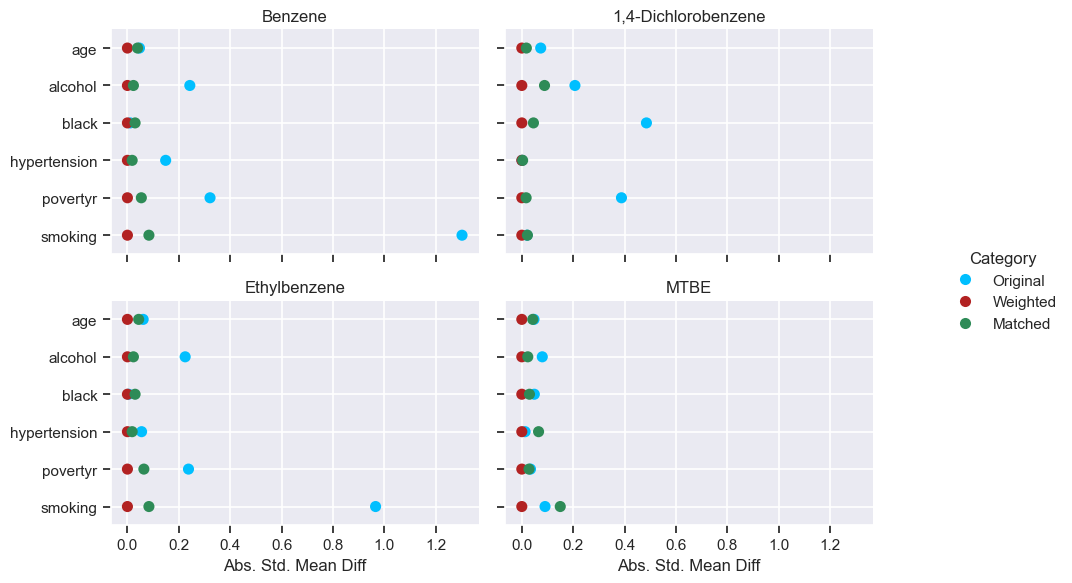

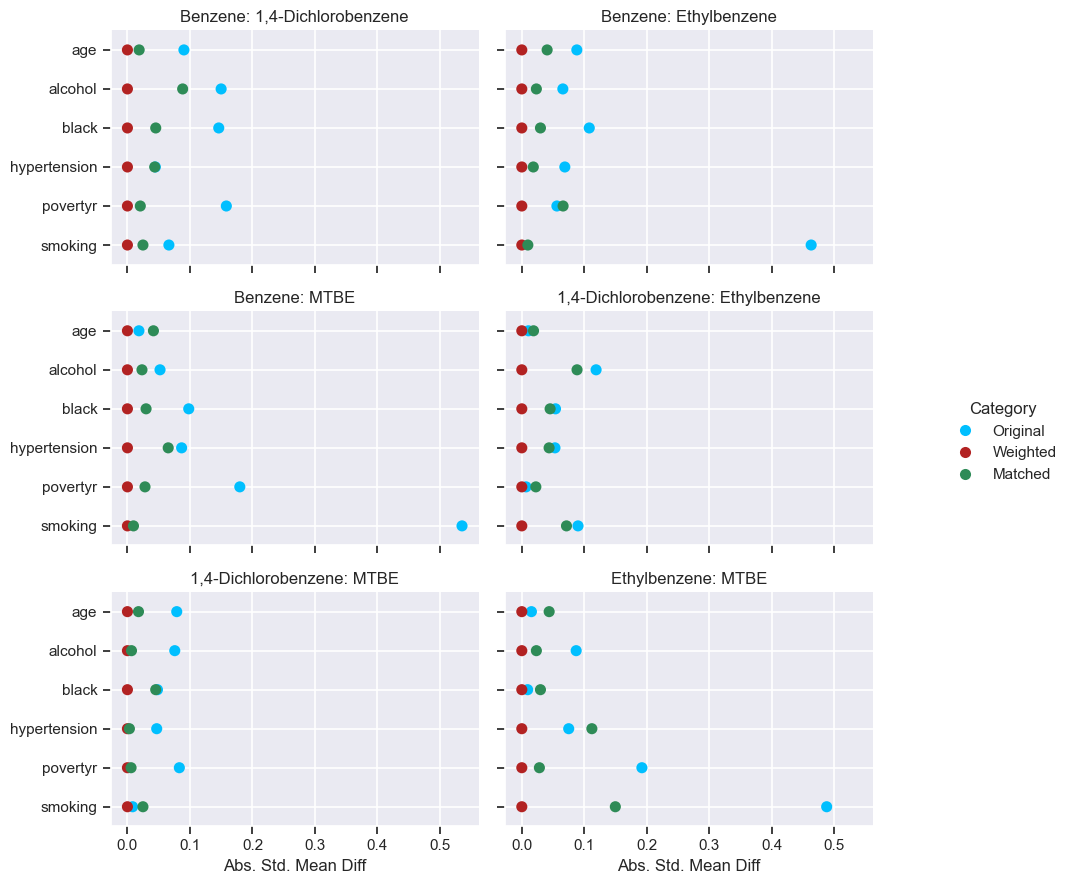


Table 1-style summary (point-estimates only)

        Type                    Treatment              Weighting Matching Regression
        Main Effect                            Benzene   -0.336    0.535     2.178  
        Main Effect                1,4-Dichlorobenzene    1.675   -0.674    -1.770  
        Main Effect                       Ethylbenzene   -0.291    0.448    -1.723  
        Main Effect                               MTBE    2.247    0.343     0.854  
Two-way Interaction      Benzene : 1,4-Dichlorobenzene    0.439   -0.038     4.325  
Two-way Interaction             Benzene : Ethylbenzene    1.734    0.815    -4.120  
Two-way Interaction                     Benzene : MTBE   -0.448   -0.255     5.760  
Two-way Interaction 1,4-Dichlorobenzene : Ethylbenzene   -1.731   -2.140    -2.505  
Two-way Interaction         1,4-Dichlorobenzene : MTBE   -0.077    0.001    -0.135  
Two-way Interaction                Ethylbenzene : MTBE   -1.509   -0.651    -4.201  


In [ ]:

def main():
    data = pd.read_csv("/Users/zengyx/Desktop/voc_hr.csv")

    treatment_cols = ["benzene", "dichlorobenzene", "ethylbenzene", "mtbe"]
    outcome_col = "heartrate"

    # Preprocessing
    for col in treatment_cols:
        data[col] = data[col].map({0: -1, 1: +1})
        
    for col in ["black", "hispanic", "alcohol", "smoking", "hypertension"]:
        data[col] = data[col].astype(int)

    covariate_cols = ["smoking", "povertyr", "hypertension", "black", "alcohol", "age"]

    Z = data[treatment_cols].values.astype(int)
    X = data[covariate_cols].values.astype(float)
    Y = data[outcome_col].values.astype(float)
    N = X.shape[0]  
    D = X.shape[1]  
    K = Z.shape[1]  

    smd_unweighted = get_covariate_balance_matched(X, Z, np.ones(N))

    weights = solve_weights_heterogeneous_2way(X, Z)
    smd_weighted = get_covariate_balance(X, Z, weights)

    match_vec = solve_matching_heterogeneous_2way(X, Z, lambda_penalty=100000.0)
    smd_matched = get_covariate_balance_matched(X, Z, match_vec)

    smd_2way_orig    = get_2way_smds(X, Z, method="original")
    smd_2way_weight  = get_2way_smds(X, Z, method="weighted", weights=weights)
    smd_2way_matched = get_2way_smds(X, Z, method="matched", selection=match_vec)

    smd_unw = np.vstack([smd_unweighted, smd_2way_orig])
    smd_w = np.vstack([smd_weighted, smd_2way_weight])
    smd_m = np.vstack([smd_matched, smd_2way_matched])

    df_smd = prepare_smd_plot_df_with_2way(
        smd_unw, smd_w, smd_m,
        covariate_names=covariate_cols,
        treatment_names=["Benzene","1,4-Dichlorobenzene","Ethylbenzene","MTBE"],
        include_2way=True
    )

    tau_main_w, tau_2way_w = estimate_main_and_2way_effects_weighted_contrast(Y, Z, weights)
    tau_main_m, tau_2way_m = estimate_main_and_2way_effects_matched(Y, Z, match_vec)
    tau_main_r, tau_2way_r = interaction_regression_het(Y, X, Z)

    print("--- Weighting ---")
    for k in sorted(tau_main_w): print(f"  τ_{k} = {tau_main_w[k]:.4f}")
    for k in sorted(tau_2way_w): print(f"  τ_{k} = {tau_2way_w[k]:.4f}")

    print("--- Matching ---")
    for k in sorted(tau_main_m): print(f"  τ_{k} = {tau_main_m[k]:.4f}")
    for k in sorted(tau_2way_m): print(f"  τ_{k} = {tau_2way_m[k]:.4f}")

    print("--- Regression ---")
    for k in sorted(tau_main_r): print(f"  τ_{k} = {tau_main_r[k]:.4f}")
    for k in sorted(tau_2way_r): print(f"  τ_{k} = {tau_2way_r[k]:.4f}")

    print("\n=== Covariate Balance: Standardized Mean Differences (SMD) ===")
    for k in range(K):
        print(f"Factor {k+1}:")
        print(f"  Original: ", smd_unweighted[k])
        print(f"  Weighted: ", smd_weighted[k])
        print(f"  Matched : ", smd_matched[k])
        print("")

    # plot_smd_separate(df_smd, covariate_cols,
    #                   ["Benzene","1,4-Dichlorobenzene","Ethylbenzene","MTBE"])
    plot_smd_combined(df_smd, covariate_cols)

    # combine main + 2-way into single dicts
    tau_weight   = {**tau_main_w, **tau_2way_w}
    tau_matching = {**tau_main_m, **tau_2way_m}
    tau_regress  = {**tau_main_r, **tau_2way_r}

    make_table_factorial_effects(tau_weight, tau_matching, tau_regress)


if __name__ == "__main__":
    main()

## Setup 2

### Approach:


I stratified the selected samples into several groups (strata) and within each stratum, and I want the distribution of covariates is balanced across treatment levels with in each strata. The method forces that, within each stratum, the contrast of treatment effects of the covariates for units receiving “+1” and “–1” treatments to be very similar (with a slack variable). 

I start with a dataset of N selected units, each with 5 covariates (stored in X) and a set of 3 treatment indicators (stored in Z, with entries either +1 or –1). The goal is to assign every unit to one of a fixed number of strata (S strata) such that within each stratum the covariate distributions between the treatment groups (for each factor and for interactions like the ones in the balancing weight method) of +1 and -1 are similar.

##### Decision Variables:
Let:
- $N$: Number of units
- $D$: Number of covariates
- $K$: Number of treatment factors
- $S$: Number of strata (fixed)


For each unit $i$ = 1, $\dots$, N and stratum $s$ = 1, $\dots$, S, define:
$$
S_{i,s} \in \{0, 1\}
$$
- $S_{i,s}$ = 1 if unit $i$ is assigned to stratum $s$.
- Constraint: Each unit is assigned to exactly one stratum:
$
\sum_{s=1}^{S} S_{i,s} = 1 \quad \forall i
$


Slack variables allow relaxed constraints:
- For each balancing constraint, introduce slack variable to loose the constraints

##### Balancing constraints per stratum (with slack):

Let $ A_{i,k}^+ = \mathbb{1}\{Z_{i,k} = +1\}$, $\quad A_{i,k}^- = \mathbb{1}\{Z_{i,k} = -1\}$

I impose for all $ k = 1,\dots,K $, all basis $ s $, all interaction sets $ J $, and all strata $ r = 1,\dots,S $:
$$
\sum_{i=1}^N S_{i,r} \cdot (A_{i,k}^+ - A_{i,k}^-) \cdot q_{sJ}(\mathbf{X}_i, \mathbf{Z}_i) = t_{k,s,J,r}^{+} - t_{k,s,J,r}^{-}
$$

##### Objective: Minimize the total imbalance across all strata and basis/interaction terms:
$$
\min_{S, t} \lambda \sum_{k,s,J,r} \left( t_{k,s,J,r}^{+} + t_{k,s,J,r}^{-} \right)
$$



In [6]:
D = 5  # number of covariates
K = 3 # number of binary covariates
rho = 0.0 # correlation
Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)
# constructs a covariance matrix where diagonal elements are 1 and off-diagonal elements are rho.
# when rho = 0.0, Sigma is an identity matrix, meaning all covariates are independent.

# coefficient vectors for generating Z 
beta1 = np.array([ 1/4,  2/4,  0.0,  3/4,  1.0])
beta2 = np.array([ 3/4,  1/4,  1.0,  0.0,  2/4])
beta3 = np.array([ 1.0,  0.0,  3/4,  2/4,  1/4])

def solve_strata_hetero(X, Z, num_strata=5, lambda_penalty=100.0):
    model = gp.Model("StrataHeteroAbsDiff_slack")
    model.setParam('OutputFlag', 0)
    
    N, D = X.shape
    K = Z.shape[1]

    # === 1. Strata assignment variables ===
    S = model.addVars(N, num_strata, vtype=GRB.BINARY, name="S")
    U = model.addVars(num_strata, vtype=GRB.BINARY, name="U")

    for s in range(num_strata):
        model.addConstr(gp.quicksum(S[i, s] for i in range(N)) >= 1 - (1 - U[s]) * N)
        model.addConstr(gp.quicksum(S[i, s] for i in range(N)) <= U[s] * N)
    model.addConstr(gp.quicksum(U[s] for s in range(num_strata)) == num_strata, name="force_all_strata_used")

    for i in range(N):
        model.addConstr(gp.quicksum(S[i, s] for s in range(num_strata)) == 1, name=f"assign_unit_{i}")

    # === 2. Build basis functions and interactions ===
    basis_vals = [np.ones(N)] + [X[:, d] for d in range(D)]
    n_s = len(basis_vals)

    # Main, 2-way, and 3-way interactions
    J_list = [()]
    for r in range(1, K+1):
        J_list += list(combinations(range(K), r))
        
    n_J = len(J_list)

    Qvals = np.zeros((N, n_s, n_J))
    for j_idx, J in enumerate(J_list):
        Zp = np.ones(N) if len(J) == 0 else np.prod(Z[:, list(J)], axis=1)
        for s_idx in range(n_s):
            Qvals[:, s_idx, j_idx] = basis_vals[s_idx] * Zp

    Aplus = (Z > 0).astype(float)
    Aminus = 1.0 - Aplus

    # === 3. Add balancing constraints (with slack) per stratum ===
    slack_vars = []
    for k in range(K):
        for s_idx in range(n_s):
            for j_idx in range(n_J):
                for s in range(num_strata):
                    t_pos = model.addVar(lb=0.0, name=f"tpos_k{k}_s{s_idx}_j{j_idx}_s{s}")
                    t_neg = model.addVar(lb=0.0, name=f"tneg_k{k}_s{s_idx}_j{j_idx}_s{s}")
                    slack_vars.extend([t_pos, t_neg])

                    lhs_diff = gp.quicksum(S[i, s] * (Aplus[i, k] - Aminus[i, k]) * Qvals[i, s_idx, j_idx] for i in range(N))
                    model.addConstr(lhs_diff == t_pos - t_neg, name=f"imbalance_k{k}_s{s_idx}_j{j_idx}_s{s}")

    # === 4. Objective: minimize total imbalance slack ===
    obj = lambda_penalty * gp.quicksum(slack_vars)
    model.setObjective(obj, GRB.MINIMIZE)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        print("Infeasible or no optimal solution found.")
        return None, None

    strata_assign = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        for s in range(num_strata):
            if S[i, s].X > 0.5:
                strata_assign[i] = s
                break

    return strata_assign, model.ObjVal

def estimate_main_effects_strata(Y, Z, strata):
    K = Z.shape[1]
    tau_est = {k+1: [] for k in range(K)}
    for s in np.unique(strata):
        idx = (strata == s)
        if np.sum(idx) < 2:
            continue
        for k in range(K):
            plus = (Z[idx, k] == 1)
            minus = (Z[idx, k] == -1)
            if np.sum(plus) < 1 or np.sum(minus) < 1:
                continue
            tau = np.mean(Y[idx][plus]) - np.mean(Y[idx][minus])
            tau_est[k+1].append(tau)
    return tau_est


def run_simulation_matching_strata(n_sims=10, D=5, K=3, N=500, lambda_penalty=100.0, num_strata=5):
    outcome_models = {
        "additive": Y_model_additive,
        "heterogeneous": Y_model_het,
        "misspecified": Y_model_mis
    }

    slack_list = []
    rmse_summary = {model: [] for model in outcome_models}
    bias_summary = {model: [] for model in outcome_models}
    stratum_rmse_tracker = {model: {} for model in outcome_models}

    mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0])
    X = np.random.multivariate_normal(mu, Sigma, size=N)
    Z = generate_treatments(X)

    for sim in range(n_sims):
        matchH = solve_matching_heterogeneous(X, Z, lambda_penalty=1.0)
        if matchH is None:
            continue
        selected = np.flatnonzero(matchH > 0.5)
        Xsel, Zsel = X[selected], Z[selected]

        clusters, slack = solve_strata_hetero(Xsel, Zsel, num_strata=num_strata, lambda_penalty=lambda_penalty)
        if clusters is None:
            continue
        slack_list.append(slack)

        for model_name, Y_fn in outcome_models.items():
            Y = Y_fn(Xsel, Zsel)
            true_tau = true_main_effects(Y_fn, combos=Z_all)

            per_stratum_rmse = []
            per_stratum_bias = []

            for s in range(num_strata):
                idx = (clusters == s)
                if np.sum(idx) < 5:
                    continue
                Ys, Zs = Y[idx], Zsel[idx]
                tau_est = estimate_main_effects_strata(Ys, Zs, np.zeros_like(Ys))

                errs = []
                biases = []
                for k in range(K):
                    if len(tau_est[k+1]) == 0:
                        continue
                    m_tau = np.mean(tau_est[k+1])
                    err = (m_tau - true_tau[k+1]) ** 2
                    bias = m_tau - true_tau[k+1]
                    errs.append(err)
                    biases.append(bias)

                if errs:
                    rmse = np.sqrt(np.mean(errs))
                    bias = np.mean(biases)
                    per_stratum_rmse.append(rmse)
                    per_stratum_bias.append(bias)

                    if s not in stratum_rmse_tracker[model_name]:
                        stratum_rmse_tracker[model_name][s] = []
                    stratum_rmse_tracker[model_name][s].append(rmse)

            if per_stratum_rmse:
                rmse_summary[model_name].append(np.mean(per_stratum_rmse))
                bias_summary[model_name].append(np.mean(per_stratum_bias))

    print(f"Running for {num_strata} strata...")
    for model_name in outcome_models:
        strata_ids = sorted(stratum_rmse_tracker[model_name].keys())
        avg_rmse_per_stratum = [
            np.mean(stratum_rmse_tracker[model_name][s]) for s in strata_ids
        ]
        mean_of_stratum_rmses = np.mean(avg_rmse_per_stratum)
        rounded_list = [round(x, 4) for x in avg_rmse_per_stratum]
        print(f"[{model_name}] RMSEs per stratum: {rounded_list} → Mean RMSE: {mean_of_stratum_rmses:.4f}")

    return {
        "slack": slack_list,
        "avg_rmse": {m: np.mean(rmse_summary[m]) for m in outcome_models},
        "var_rmse": {m: np.var(rmse_summary[m]) for m in outcome_models},
        "avg_bias": {m: np.mean(bias_summary[m]) for m in outcome_models},
        "var_bias": {m: np.var(bias_summary[m]) for m in outcome_models},
    }


def plot_strata_simulation_results(strata_vals, results_by_strata):
    models = ["additive", "heterogeneous", "misspecified"]

    avg_slacks = [np.mean(r['slack']) for r in results_by_strata]
    rmse_variances = {m: [r['var_rmse'][m] for r in results_by_strata] for m in models}
    bias_variances = {m: [r['var_bias'][m] for r in results_by_strata] for m in models}
    avg_rmses = {m: [r['avg_rmse'][m] for r in results_by_strata] for m in models}

    plt.figure()
    plt.plot(strata_vals, avg_slacks, marker='o')
    plt.xlabel("Number of Strata")
    plt.ylabel("Average Total Slack")
    plt.title("Slack vs Number of Strata")
    plt.grid(True)
    plt.show()

    plt.figure()
    for m in models:
        plt.plot(strata_vals, rmse_variances[m], marker='o', label=f"{m}")
    plt.xlabel("Number of Strata")
    plt.ylabel("Variance of RMSE")
    plt.title("Variance of RMSE by Model vs Number of Strata")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    for m in models:
        plt.plot(strata_vals, bias_variances[m], marker='o', label=f"{m}")
    plt.xlabel("Number of Strata")
    plt.ylabel("Variance of Bias")
    plt.title("Variance of Bias by Model vs Number of Strata")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    for m in models:
        plt.plot(strata_vals, avg_rmses[m], marker='o', label=f"{m}")
    plt.xlabel("Number of Strata")
    plt.ylabel("Average RMSE (Per-Stratum Averaged)")
    plt.title("Average RMSE by Model vs Number of Strata")
    plt.legend()
    plt.grid(True)
    plt.show()



In [3]:
def main():
    np.random.seed(123)
    D = 5 
    K = 3
    n_sims = 1
    N = 200
    lambda_penalty = 1
    strata_vals = list(range(2, 9))  # 2 to 8 strata

    results_by_strata = []
    print("\n==== Starting Strata Simulation ====\n")

    for num_strata in strata_vals:
        result = run_simulation_matching_strata(
            n_sims=n_sims, D=D, K=K, N=N,
            lambda_penalty=lambda_penalty, num_strata=num_strata
        )
        results_by_strata.append(result)

    print("\n==== Completed All Strata Levels ====")
    plot_strata_simulation_results(strata_vals, results_by_strata)


if __name__ == "__main__":
    main()


==== Starting Strata Simulation ====

Set parameter Username
Set parameter LicenseID to value 2622621
Academic license - for non-commercial use only - expires 2026-02-16
Running for 2 strata...
[additive] RMSEs per stratum: [np.float64(1.0515), np.float64(0.6666)] → Mean RMSE: 0.8590
[heterogeneous] RMSEs per stratum: [np.float64(0.79), np.float64(0.7406)] → Mean RMSE: 0.7653
[misspecified] RMSEs per stratum: [np.float64(0.2577), np.float64(0.2303)] → Mean RMSE: 0.2440
